# Sandbox - Generate Data

This notebook is used to prototype the generate_data function, used to generate all scenarios of use of the algorithm.

---

## Imports & Config

In [1]:
# Jax configuration
USE_JIT = False
USE_X64 = True
DEBUG_NANS = False
VERBOSE = False

In [2]:
# Standard library imports
import os
os.environ['JAX_ENABLE_X64'] = str(USE_X64).lower()

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# Third party
import jax
jax.config.update("jax_disable_jit", not USE_JIT)
jax.config.update("jax_debug_nans", DEBUG_NANS)

In [4]:
from typing import Tuple
import math
import jax.random as jr
import jax.numpy as jnp
from jax import vmap, jit, Array
from jax.tree_util import tree_map_with_path, GetAttrKey, tree_unflatten, tree_flatten
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np

In [5]:
from kernax import BlockKernel, BlockDiagKernel, BatchKernel, WhiteNoiseKernel, BlockDiagKernel, FeatureKernel
from mimosa.custom_kernels import RBFKernel
from mimosa.linalg import compute_mapping

---

## Generate master function

In [27]:
def compute_priors(grid_size: int, dim: int, feat:int, input_range: tuple[int, int],
                   output_range: tuple[int, int]) -> dict[str, tuple[float, float]]:
	"""
	Compute reasonable prior bounds for GP hyperparameters.

	Args:
	    grid_size: Number of points per dimension
	    dim: Input dimensionality
	    input_range: (min, max) values for input components
	    output_range: (min, max) values for output components

	Returns:
	    Dictionary with prior bounds for 'length_scale', 'variance', 'value' (noise)
	"""
	# Computes spans
	input_span = input_range[1] - input_range[0]
	output_span = output_range[1] - output_range[0]

	# Smallest possible distance between two points in the grid, when only one dimension differs
	min_length_scale = (input_span / (grid_size - 1)) * 4  # Reasonable min distance

	# Average square distance between two points in an hypercube of dimension I
	avg_sq_dist = input_span ** 2 * dim / 6
	max_length_scale = math.sqrt(avg_sq_dist) / grid_size * 16  # Reasonable max distance

	if feat == 1:
		length_scale_prior = (min_length_scale*2, max_length_scale*2)
		length_scale_u_prior = (min_length_scale*2, max_length_scale*2)  # Should be useless
	else:  # Multi-feature means we have 3 distinct length scales that are summed, so we reduce their ranges
		length_scale_prior = (min_length_scale*4, max_length_scale*4)
		length_scale_u_prior = (min_length_scale*8, max_length_scale*8)

	# Variance prior based on output span
	variance_min = 0.25 * output_span
	variance_max = 0.75 * output_span

	if feat == 1:
		variance_prior = (variance_min, variance_max)
	else:  # Multi-feature means we have 2 distinct variances that are multiplied, so we reduce their ranges
		variance_prior = (jnp.sqrt(variance_min), jnp.sqrt(variance_max))

	# Noise prior based on output span
	noise_min = 0.05 * output_span * 10
	noise_max = 0.1 * output_span * 10
	noise_prior = (noise_min, noise_max)

	return {
		'length_scale': length_scale_prior,
		'length_scale_u': length_scale_u_prior,
		'_unconstrained_length_scale': length_scale_prior,
		'_unconstrained_length_scale_u': length_scale_u_prior,
		'variance': variance_prior,
		'_unconstrained_variance': variance_prior,
		'value': noise_prior,
		'_unconstrained_value': noise_prior,
		'noise': noise_prior,
		'_unconstrained_noise': noise_prior
	}

In [28]:
compute_priors(grid_size=100, dim=1, feat=1, input_range=(-50, 50), output_range=(-10, 10))

{'length_scale': (8.080808080808081, 13.063945294843618),
 'length_scale_u': (8.080808080808081, 13.063945294843618),
 '_unconstrained_length_scale': (8.080808080808081, 13.063945294843618),
 '_unconstrained_length_scale_u': (8.080808080808081, 13.063945294843618),
 'variance': (5.0, 15.0),
 '_unconstrained_variance': (5.0, 15.0),
 'value': (10.0, 20.0),
 '_unconstrained_value': (10.0, 20.0),
 'noise': (10.0, 20.0),
 '_unconstrained_noise': (10.0, 20.0)}

In [29]:
compute_priors(grid_size=100, dim=2, feat=2, input_range=(-50, 50), output_range=(-10, 10))

{'length_scale': (16.161616161616163, 36.95041722813605),
 'length_scale_u': (32.323232323232325, 73.9008344562721),
 '_unconstrained_length_scale': (16.161616161616163, 36.95041722813605),
 '_unconstrained_length_scale_u': (32.323232323232325, 73.9008344562721),
 'variance': (Array(2.23606798, dtype=float64, weak_type=True),
  Array(3.87298335, dtype=float64, weak_type=True)),
 '_unconstrained_variance': (Array(2.23606798, dtype=float64, weak_type=True),
  Array(3.87298335, dtype=float64, weak_type=True)),
 'value': (10.0, 20.0),
 '_unconstrained_value': (10.0, 20.0),
 'noise': (10.0, 20.0),
 '_unconstrained_noise': (10.0, 20.0)}

In [30]:
def generate_grid(n_points, n_dims, bounds):
    """
    Generate a regular grid in n_dims with n_points along each dimension, bounded by bounds

    Args:
        n_points: Nb point per dimension (granularity of the grid)
        n_dims: Nb of dimensions
        bounds: bounds of values in the grid

    Returns:
        Un array de shape (n_points**n_dims, n_dims) contenant toutes les combinaisons
    """
    axis = jnp.linspace(bounds[0], bounds[1], n_points)

    grids = jnp.meshgrid(*([axis] * n_dims), indexing='ij')

    return jnp.stack(grids, axis=-1).reshape(-1, n_dims)

In [31]:
def build_kernels(
		T: int,
		F: int,
		O: int,
		K: int,
		feature_hps: bool = False,
		shared_output_hps: bool = True,
		cluster_hps: bool = False,
		shared_task_hps: bool = True,
		shared_inputs_in_features: bool = True,
		shared_inputs_in_tasks: bool = True):
	"""
	Build mean and task kernels for data generation based on specified hyperparameter structure.

	This function constructs appropriate kernel hierarchies depending on the number of features,
	outputs, clusters, and whether hyperparameters should be shared across these dimensions.

	Args:
		F: Number of features
		O: Dimension of output points
		K: Number of clusters
		feature_hps: Whether features have distinct hyperparameters
		shared_output_hps: Whether output dimensions share hyperparameters
		cluster_hps: Whether clusters have distinct hyperparameters
		shared_task_hps: Whether tasks share hyperparameters
		shared_inputs_in_features: Whether all features are observed on the same sampled grid
		shared_inputs_in_tasks: Whether all tasks are observed on the same sampled grid

	Returns:
		Tuple of (mean_kernel, task_kernel) configured according to the specified structure
	"""
	# TODO: integrate ARD kernel (but where?)
	if F == 1:
		# Standard SEKernel
		mean_kernel = RBFKernel(length_scale=1., variance=1.)
		task_kernel = RBFKernel(length_scale=1., variance=1.) + WhiteNoiseKernel(1.)
	else:
		# Multi-feature kernel
		mean_kernel = FeatureKernel(length_scale=1.,  length_scale_u=1., variance=1.)
		task_kernel = FeatureKernel(length_scale=1., length_scale_u=1., variance=1.) + WhiteNoiseKernel(1.)

		# feature HP
		if feature_hps:
			mean_bia = eqx.tree_at(lambda k: (k.length_scale, k.length_scale_u, k.variance),
			                       mean_kernel,
			                       (0, None, 0))
			task_bia = eqx.tree_at(lambda k: (k.length_scale, k.length_scale_u, k.variance),
			                       task_kernel.left_kernel,
			                       (0, None, 0))

			# --- wouldn't work as WhiteNoiseKernel doesn't expect to receive two noises
			#task_bia = eqx.tree_at(lambda k: (k.left_kernel.length_scale, k.left_kernel.length_scale_u, k.left_kernel.variance, k.right_kernel.value),
			#                       task_kernel,
			#                       (0, None, 0, 0))

		else:
			mean_bia = None
			task_bia = None

		mean_kernel = BlockKernel(mean_kernel,
		                          nb_blocks=F,
		                          block_in_axes=mean_bia,
		                          block_over_inputs=not shared_inputs_in_features)
		task_kernel = (BlockKernel(task_kernel.left_kernel,
		                           nb_blocks=F,
		                           block_in_axes=task_bia,
		                           block_over_inputs=not shared_inputs_in_features) +
		               BlockDiagKernel(task_kernel.right_kernel,
		                               nb_blocks=F,
		                               block_in_axes=0 if feature_hps else None,
		                               block_over_inputs=not shared_inputs_in_features))

	# multi-output HPs
	if not shared_output_hps:
		mean_kernel = BatchKernel(mean_kernel, batch_size=O, batch_in_axes=0, batch_over_inputs=False)
		task_kernel = BatchKernel(task_kernel, batch_size=O, batch_in_axes=0, batch_over_inputs=False)
	else:
		mean_kernel = BatchKernel(mean_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)
		task_kernel = BatchKernel(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)


	# cluster HPs
	if cluster_hps:
		mean_kernel = BatchKernel(mean_kernel, batch_size=K, batch_in_axes=0, batch_over_inputs=False)
		task_kernel = BatchKernel(task_kernel, batch_size=K, batch_in_axes=0, batch_over_inputs=False)
	else:
		mean_kernel = BatchKernel(mean_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)
		task_kernel = BatchKernel(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)


	# task HPs
	if shared_task_hps:
		if shared_inputs_in_tasks:
			task_kernel = BatchKernel(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)
		else:
			task_kernel = BatchKernel(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=True)
	else:
		if shared_inputs_in_tasks:
			task_kernel = BatchKernel(task_kernel, batch_size=T, batch_in_axes=0, batch_over_inputs=False)
		else:
			task_kernel = BatchKernel(task_kernel, batch_size=T, batch_in_axes=0, batch_over_inputs=True)

	return mean_kernel, task_kernel

In [32]:
def initialize_kernel(key, kernel, priors):
    """
    Initialise les hyper-paramètres d'un kernel Equinox arbitraire.
    """

    # 1. Génération de l'arbre de clés (Key Tree)
    # On a besoin d'une sous-clé unique pour chaque feuille du kernel pour garantir
    # l'indépendance statistique.
    leaves, treedef = tree_flatten(kernel)
    keys = jr.split(key, len(leaves))
    key_tree = tree_unflatten(treedef, keys)

    # 2. Helper pour trouver les bornes dans la config
    def get_bounds(name):
        # Cherche d'abord à la racine (ex: input_range)
        if name in priors:
            return priors[name]
        return None

    # 3. Fonction de transformation
    def init_leaf(path, leaf, subkey):
        # Condition A : On ignore ce qui n'est pas un array JAX (int, str, None...)
        # eqx.is_array renvoie True pour jax.Array et numpy array, mais False pour int/float python
        if not eqx.is_array(leaf):
            return leaf

        # Condition B : On vérifie le nom de l'attribut
        # path[-1] est la clé de la feuille courante.
        # Si c'est un attribut de classe, c'est un GetAttrKey.
        if len(path) > 0 and isinstance(path[-1], GetAttrKey):
            param_name = path[-1].name
            bounds = get_bounds(param_name)

            if bounds is not None:
                min_val, max_val = bounds

                # On sample en préservant la shape de la leaf
                # JAX gère automatiquement le broadcasting du min/max si ce sont des scalaires
                return jr.uniform(
                    subkey,
                    shape=leaf.shape,
                    minval=min_val,
                    maxval=max_val
                )

        # Si aucune condition n'est remplie, on renvoie la feuille intacte
        return leaf

    # 4. Exécution du mapping sur le kernel ET l'arbre de clés
    # On passe key_tree comme 3ème argument, tree_map va itérer dessus en parallèle du kernel
    return tree_map_with_path(init_leaf, kernel, key_tree)

In [33]:
@jit
def sample_gp(key, inputs, mean, cov, jitter=jnp.array(1e-3)) -> Array:
	"""
	Sample outputs from a gaussian process given inputs, mean(s) and kernel(s)

	:param key: JAX PRNG key
	:param inputs: the grid on which to sample. Shape (N, I)
	:param mean: the mean(s) of the generative process for each output dim. Shape (N,) or (N, O)
	:param cov: the covariance matrix. Should have shape (N, N) or (O, N, N)

	:return: generated outputs. Shape (N, O)
	"""
	return jr.multivariate_normal(key, mean.T, cov + jnp.eye(cov.shape[-1])*jitter).T

In [34]:
def plot_processes_1D(g, m_p):
	"""
	Plot the mean process of each cluster, for each feature and output dimension, when inputs are 1D

	Clusters are rows, features are columns.
	All output dimensions are plotted as separate curves when O>1.

	:param g: Input grid. Shape (G, 1) where G is grid_size
	:param m_p: Mean processes. Shape (K, F*G, O) where K is number of clusters, F is number of features, G is grid size and O is output dimension
	"""
	# Extract dimensions from data
	K = m_p.shape[0]
	O = m_p.shape[2]
	G = g.shape[0]
	F = m_p.shape[1] // G
	
	# Handle subplot axes indexing - K rows × F columns
	if K == 1 and F == 1:
		fig, ax = plt.subplots(1, 1, figsize=(8, 6))
		axes = [[ax]]
	elif K == 1:
		fig, axes_arr = plt.subplots(1, F, figsize=(4*F, 4))
		axes = [axes_arr if F > 1 else [axes_arr]]
	elif F == 1:
		fig, axes_arr = plt.subplots(K, 1, figsize=(8, 4*K))
		axes = [[ax] for ax in (axes_arr if K > 1 else [axes_arr])]
	else:
		fig, axes = plt.subplots(K, F, figsize=(4*F, 4*K))
		if not isinstance(axes[0], np.ndarray):
			axes = [[ax] for ax in axes]

	grid_size_per_feature = G

	for k in range(K):
		for f in range(F):
			# Extract data for this cluster and feature
			start_idx = f * grid_size_per_feature
			end_idx = (f + 1) * grid_size_per_feature

			# Plot all output dimensions as separate curves
			for o in range(O):
				data = m_p[k, start_idx:end_idx, o]
				if O > 1:
					axes[k][f].plot(g[:, 0], data, label=f'Output {o}')
				else:
					axes[k][f].plot(g[:, 0], data)
			
			if O > 1:
				axes[k][f].legend()

			axes[k][f].set_xlabel('Input')
			axes[k][f].set_ylabel('Output')
			axes[k][f].set_title(f'Cluster {k}, Feature {f}')
			axes[k][f].grid(True)
			axes[k][f].set_xlim(-50, 50)
			axes[k][f].set_ylim(-10, 10)

	plt.tight_layout()
	plt.show()

In [35]:
def plot_processes_2D(g, m_p):
	"""
	Plot the mean process of each cluster, for each feature and output dimension, when inputs are 2D

	Clusters are rows, features are columns.
	Only the first output dimension (o_id=0) is plotted, as 3D surface plots can only show one output at a time.

	:param g: Input grid. Shape (G**2, 2) where G is grid_size
	:param m_p: Mean processes. Shape (K, F*G**2, O) where K is number of clusters, F is number of features, G is grid size and O is output dimension
	"""
	# Extract dimensions from data
	K = m_p.shape[0]
	O = m_p.shape[2]
	G = g.shape[0]
	F = m_p.shape[1] // G
	o_id = 0  # Always plot first output dimension for 2D inputs
	
	# Handle subplot axes indexing - K rows × F columns
	if K == 1 and F == 1:
		fig = plt.figure(figsize=(8, 6))
		ax = fig.add_subplot(111, projection='3d')
		axes = [[ax]]
	elif K == 1:
		fig = plt.figure(figsize=(5*F, 5))
		axes = [[fig.add_subplot(1, F, f+1, projection='3d') for f in range(F)]]
	elif F == 1:
		fig = plt.figure(figsize=(8, 5*K))
		axes = [[fig.add_subplot(K, 1, k+1, projection='3d')] for k in range(K)]
	else:
		fig = plt.figure(figsize=(5*F, 5*K))
		axes = [[fig.add_subplot(K, F, k*F + f + 1, projection='3d') for f in range(F)] for k in range(K)]

	grid_size_per_feature = G

	for k in range(K):
		for f in range(F):
			# Extract data for this cluster, feature, and first output dimension
			start_idx = f * grid_size_per_feature
			end_idx = (f + 1) * grid_size_per_feature
			data = m_p[k, start_idx:end_idx, o_id]

			# Plot 3D surface for 2D input
			axes[k][f].plot_trisurf(g[:, 0], g[:, 1], data, cmap='viridis')
			axes[k][f].set_xlabel('Input 1')
			axes[k][f].set_ylabel('Input 2')
			axes[k][f].set_zlabel('Output')
			axes[k][f].set_title(f'Cluster {k}, Feature {f}, Output {o_id}')
			axes[k][f].set_xlim(-50, 50)
			axes[k][f].set_ylim(-50, 50)
			axes[k][f].set_zlim(-10, 10)

	plt.tight_layout()
	plt.show()

In [36]:
def plot_task_means_1D(g, m_p, full_i, task_means, mix):
	"""
	Plot the mean process of each cluster with individual tasks points overlaid, for 1D inputs

	Clusters are rows, features are columns.
	Tasks are plotted on top of their assigned cluster's mean process, as points.
	All output dimensions are plotted as separate curves when O>1.

	:param g: Input grid. Shape (G, 1) where G is grid_size
	:param m_p: Mean processes. Shape (K, F*G, O)
	:param full_i: Task inputs. Shape (T, F*N, I)
	:param task_means: Task means. Shape (T, F*N, O)
	:param mix: Task-to-cluster assignment. Shape (T,)
	"""
	# Extract dimensions from data
	K = m_p.shape[0]
	O = task_means.shape[2]  # Output dimensions (same as m_p.shape[2])
	G = g.shape[0]
	F = m_p.shape[1] // G
	T = task_means.shape[0]
	N = full_i.shape[1] // F  # Number of points per feature
	
	# Handle subplot axes indexing - K rows × F columns
	if K == 1 and F == 1:
		fig, ax = plt.subplots(1, 1, figsize=(8, 6))
		axes = [[ax]]
	elif K == 1:
		fig, axes_arr = plt.subplots(1, F, figsize=(4*F, 4))
		axes = [axes_arr if F > 1 else [axes_arr]]
	elif F == 1:
		fig, axes_arr = plt.subplots(K, 1, figsize=(8, 4*K))
		axes = [[ax] for ax in (axes_arr if K > 1 else [axes_arr])]
	else:
		fig, axes = plt.subplots(K, F, figsize=(4*F, 4*K))
		if not isinstance(axes[0], np.ndarray):
			axes = [[ax] for ax in axes]

	grid_size_per_feature = G

	# Define colors for each output dimension
	colors = plt.cm.tab10(range(O))

	for k in range(K):
		for f in range(F):
			# Extract and plot mean process for this cluster and feature
			start_idx = f * grid_size_per_feature
			end_idx = (f + 1) * grid_size_per_feature

			# Plot all output dimensions as separate curves
			for o in range(O):
				data = m_p[k, start_idx:end_idx, o]
				axes[k][f].plot(g[:, 0], data, label=f'Mean Process Output {o}' if O > 1 else 'Mean Process',
				               color=colors[o], linewidth=2, alpha=0.5)

			# Overlay tasks that belong to this cluster
			for t in range(T):
				if mix[t] == k:
					# Extract task inputs and means for this feature
					task_start_idx = f * N
					task_end_idx = (f + 1) * N

					task_inputs = full_i[t, task_start_idx:task_end_idx, 0]  # Shape (N,)
					task_outputs = task_means[t, task_start_idx:task_end_idx, :]  # Shape (N, O)

					# Plot all output dimensions
					for o in range(O):
						axes[k][f].plot(task_inputs, task_outputs[:, o],
						               color=colors[o], alpha=0.3, marker='.', linestyle='None'),
						               # label=f'Task {t} Output {o}' if f == 0 and O > 1 else (f'Task {t}' if f == 0 else ''))

			axes[k][f].set_xlabel('Input')
			axes[k][f].set_ylabel('Output')
			axes[k][f].set_title(f'Cluster {k}, Feature {f}')
			axes[k][f].grid(True)
			axes[k][f].set_xlim(-50, 50)
			axes[k][f].set_ylim(-10, 10)

			# Only show legend on the first subplot to avoid clutter
			if k == 0 and f == 0:
				axes[k][f].legend(fontsize=8, loc='best')

	plt.tight_layout()
	plt.show()

In [37]:
key = jr.PRNGKey(42)

In [47]:
def generate_data(
		key, T:int, K:int, F:int, N:int, I:int, O:int, grid_size:int,
		shared_task_hps: bool = True,
		cluster_hps: bool = False,
		feature_hps:bool = False,
		ard_inputs:bool = False,
		shared_output_hps:bool = True,
		shared_inputs_in_tasks: bool = True,
		shared_inputs_in_features: bool = True,
		missing_inputs_ratio:float = 0.,
		missing_output_dim_ratio:float = 0.,
		same_size_clusters:bool = True,
		input_range:Tuple[int, int] = (-50, 50),
		output_range:Tuple[int, int] = (-10, 10),
		priors=None,
):
	"""
	--- PRNG parameters ---
	:param key: `jax.random` PRNG key

	--- Dataset size parameters ---
	:param T: Number of tasks
	:param K: Number of clusters
	:param F: Number of features
	:param N: Number of points for each feature of each task
	:param I: Dimension of input points
	:param O: Dimension of output points

	--- Hyper-parameters options ---
	:param shared_task_hps: Whether tasks share hyper-parameters
	:param cluster_hps: Whether task have cluster-specific hyper-parameters
	:param feature_hps: Whether features share hyper-parameters
	:param ard_inputs: Whether inputs dimensions have different weights for covariance between points
	:param shared_output_hps: Whether outputs dimensions share hyper-parameters

	--- Sampling options ---
	:param grid_size: Grid size along each dimension. Ex: if I=2 and grid_size=10, inputs will be sampled from a regular 2D grid containing 10**2 = 100 points, from [input_range[0], input_range[0]] to [input_range[1], input_range[1]]
	:param shared_inputs_in_tasks: Whether all tasks are observed on the same sampled grid
	:param shared_inputs_in_features: Whether all features are observed on the same sampled grid
	:param missing_inputs_ratio: How much of the input points should be missing in each task (between 0 and 1)
	:param missing_output_dim_ratio: Probability of an output missing a dimension, in multi-output scenarios (between 0 and 1)
	:param same_size_clusters: If True and T is a multiple of K, all clusters will have the same number of tasks. Otherwise, tasks are randomly assigned to clusters.

	--- Configuration parameters ---
	:param input_range: Min and max value for input points (applied to every input dimensions)
	:param output_range: Min and max value for output points (applied to every output dimensions)
	:param priors: Dictionary of prior ranges for hyper-parameters randomisation. If not provided, appropriate priors will be computed based on input/output ranges, input dimension and grid size.

	:return: inputs (Shape (T, F, N**I, I)), outputs (Shape (T, F, N**I, O)), mixture (Shape T, K) and the mean kernel and task kernel used to generate the data
	"""
	assert grid_size**I >= N, f"Cannot sample N={N} points in a grid containing {grid_size**I} points (= {grid_size}^{I})"
	assert I > 1 or not ard_inputs, f"Cannot set ard_inputs={ard_inputs} when having only {I} input dimensions"
	assert O > 1 or shared_output_hps, f"No need to differentiate hyper-parameters for outputs when having only {O} output dimension"
	assert K > 1 or not cluster_hps, f"No need for cluster-specific hyper-parameters when having only {K} cluster"
	assert F > 1 or not feature_hps, f"No need for feature-specific hyper-parameters when having only {F} feature"

	if priors is None:
		priors = compute_priors(grid_size, I, F, input_range, output_range)

	# Step 1: sample the input grid(s)
	grid = generate_grid(grid_size, I, input_range)  # Shape (G, I) where G = grid_size**I
	key, subkey = jr.split(key)
	if shared_inputs_in_tasks:
		if shared_inputs_in_features:
			# The input grid is unique to all tasks and features
			inputs = jr.choice(subkey, grid, (N,), replace=False)  # Shape (N, I)
			mappings = compute_mapping(grid, inputs)  # Shape (N,)

			#inputs = inputs[None, None, :, :]  # Shape (1, 1, N, I)
			#inputs = jnp.broadcast_to(inputs, (T, F, N, I))  # Shape (T, F, N, I)
		else:
			# The input grid is unique to all tasks but varies between features
			inputs = jr.choice(subkey, grid, (F, N), replace=False)  # Shape (F, N, I)
			mappings = vmap(lambda i: compute_mapping(grid, i))(inputs)  # Shape (F, N)

			#inputs = inputs[None, :, :, :]  # Shape (1, F, N, I)
			#inputs = jnp.broadcast_to(inputs, (T, F, N, I))  # Shape (T, F, N, I)
	else:
		if shared_inputs_in_features:
			# The input grid varies between tasks but is shared between features
			inputs = jr.choice(subkey, grid, (T, N), replace=False)  # Shape (T, N, I)
			mappings = vmap(lambda i: compute_mapping(grid, i))(inputs)  # Shape (T, N)

			#inputs = inputs[:, None, :, :]  # Shape (T, 1, N, I)
			#inputs = jnp.broadcast_to(inputs, (T, F, N, I))  # Shape (T, F, N, I)
		else:
			# The input grid varies between tasks and between features within each task
			inputs = jr.choice(subkey, grid, (T, F, N), replace=False)  # Shape (T, F, N, I)
			mappings = vmap(vmap(lambda i: compute_mapping(grid, i)))(inputs)  # Shape (T, F, N)

	# Step 2: build kernels
	mean_kernel, task_kernel = build_kernels(
		T=T,
		F=F,
		O=O,
		K=K,
		feature_hps=feature_hps,
		shared_output_hps=shared_output_hps,
		cluster_hps=cluster_hps,
		shared_task_hps=shared_task_hps,
		shared_inputs_in_features=shared_inputs_in_features,
		shared_inputs_in_tasks=shared_inputs_in_tasks
	)

	# Step 3: randomise HPs
	key, subkey1, subkyey2 = jr.split(key, 3)
	mean_kernel = initialize_kernel(subkey1, mean_kernel, priors)
	# For tasks, we use a much smaller variance
	#priors["variance"] = (priors["variance"][0]*0.5, priors["variance"][1]*0.5)
	#priors["_unconstrained_variance"] = (priors["_unconstrained_variance"][0]*0.5, priors["_unconstrained_variance"][1]*0.5)
	task_kernel = initialize_kernel(subkyey2, task_kernel, priors)

	# Step 4: sample mean processes for each cluster
	key, subkey = jr.split(key)
	if shared_inputs_in_features:
		sampling_grid = grid
	else:
		sampling_grid = jnp.tile(grid, (F,) + (1,) * grid.ndim)  # Shape (F*G, I)
	prior_mean = jnp.zeros((grid.shape[0] * F,))

	"""
	if cluster_hps:  # No need to add dimension, as mean_kernel is already batched over clusters
		mean_processes = sample_gp(subkey, sampling_grid, prior_mean, mean_kernel)
	else:
		prior_mean = jnp.broadcast_to(prior_mean, (K,) + prior_mean.shape)
		subkeys = jr.split(subkey, K)
		mean_processes = vmap(lambda k, m: sample_gp(k, sampling_grid, m, mean_kernel))(subkeys, prior_mean)
	"""
	key, subkey = jr.split(key)
	cov = mean_kernel(sampling_grid)
	if cov.shape[-1] != O:  # No batch over output dimensions, we vmap over them
		subkeys = jr.split(subkey, O)
		mean_processes = vmap(lambda k: sample_gp(k, sampling_grid, prior_mean, cov[:, 0, :, :]))(subkeys)  # Shape (O, F*G, K)
		mean_processes = mean_processes.swapaxes(0, 2)
	else:
		mean_processes = sample_gp(subkey, sampling_grid, prior_mean, cov)  # Shape (O, K, F*G)
		mean_processes = jnp.swapaxes(mean_processes.swapaxes(0, 2), 1, 2)  # Shape (K, F*G, O)

	if jnp.any(jnp.isnan(mean_processes)):
		raise RuntimeError(f"NaNs in mean processes ({jnp.count_nonzero(jnp.isnan(mean_processes))/math.prod(mean_processes.shape)*100:.2f}% of values are NaN)")

	# Step 5: assign tasks to clusters
	if same_size_clusters:
		mixture = jnp.argmax(jnp.eye(K)[jnp.arange(T) // K], axis=1)  # Shape (T,)
	else:
		key, subkey = jr.split(key)
		mixture = jnp.argmax(jr.choice(subkey, jnp.eye(K), (T,), replace=True), axis=1)  # Shape (T,)

	# Step 6: Recover means of every task based on their cluster assignment and input grid
	if shared_inputs_in_tasks and shared_inputs_in_features:
		full_inputs = jnp.repeat(jnp.repeat(inputs[None, None, :, :], F, axis=1), T, axis=0).reshape(T, -1, I)
		task_means = mean_processes[mixture].reshape(T, F, -1, O)[:, :, mappings, :].reshape(T, -1, O)
	elif shared_inputs_in_tasks and not shared_inputs_in_features:
		full_inputs = jnp.repeat(inputs[None, :, :], T, axis=0).reshape(T, -1, I)
		task_means = vmap(lambda m_p_t: vmap(lambda m_p_f, map_f: m_p_f[map_f, :])(m_p_t.reshape(F, -1, O), mappings))(mean_processes[mixture]).reshape(T, -1, O)
	elif not shared_inputs_in_tasks and shared_inputs_in_features:
		full_inputs = jnp.repeat(inputs[:, None, :, :], F, axis=1).reshape(T, -1, I)
		task_means = vmap(lambda m_p_t, map_t: m_p_t.reshape(F, -1, O)[:, map_t, :].reshape(-1, O).swapaxes(-1, -2))(mean_processes[mixture], mappings).swapaxes(-1, -2)
	else:
		full_inputs = inputs.reshape(T, -1, I)
		task_means = vmap(lambda m_p_t, map_t: vmap(lambda m_p_f, map_f: m_p_f[map_f, :])(m_p_t.reshape(F, -1, O), map_t))(mean_processes[mixture], mappings).reshape(T, -1, O)

	# Step 6: sample outputs on the input grid(s) using kernel
	key, subkey = jr.split(key)
	subkeys = jr.split(subkey, T)
	task_covs = task_kernel(inputs)
	if task_covs.shape[0] == 1:  # HPs are shared between clusters
		full_outputs = vmap(lambda key, i, m, mi: sample_gp(key, i, m, task_covs[0, mi, :, :, :]))(subkeys, full_inputs, task_means, mixture)
	else:
		full_outputs = vmap(lambda key, i, m, c, mi: sample_gp(key, i, m, c[mi, :, :, :]))(subkeys, full_inputs, task_means, task_covs, mixture)

	# full_inputs has shape (T, F*N, I) | full_outputs has shape (T, F*N, O)

	# Step 7a: remove inputs/outputs at random in each task, according to missing_inputs_ratio
	# Note: NaNs propagate from inputs to outputs, aka no output point can be observed if its corresponding input point is missing.
	if missing_inputs_ratio > 0:
		key, subkey = jr.split(key)
		subkeys = jr.split(subkey, T)

		def mask_task_points(key, inputs, outputs):
			n_points = inputs.shape[0]
			n_missing = int(missing_inputs_ratio * n_points)
			# Select random indices to mask
			indices = jr.choice(key, n_points, (n_missing,), replace=False)
			# Create mask (True = keep, False = remove)
			mask = jnp.ones(n_points, dtype=bool)
			mask = mask.at[indices].set(False)
			# Apply mask (NaN for masked points)
			inputs = jnp.where(mask[:, None], inputs, jnp.nan)
			outputs = jnp.where(mask[:, None], outputs, jnp.nan)
			return inputs, outputs

		full_inputs, full_outputs = vmap(mask_task_points)(subkeys, full_inputs, full_outputs)

	# Step 7b: remove output dimensions at random, according to missing_output_dim_ratio, in multi-output scenarios (O>1)
	# Note: each non-NaN input must be related to at least one non-NaN output, aka not all output dimensions can be missing for a given input.
	if missing_output_dim_ratio > 0 and O > 1:
		key, subkey = jr.split(key)
		# Generate random mask for all dimensions (True = keep, False = remove)
		mask = jr.bernoulli(subkey, 1 - missing_output_dim_ratio, shape=full_outputs.shape)

		# Check which points are non-NaN (not masked in step 7a)
		non_nan_points = ~jnp.isnan(full_outputs[:, :, 0])  # (T, N) - check first dim as proxy

		# Check which points would have all dimensions masked
		all_masked = jnp.sum(mask, axis=2) == 0  # (T, N)

		# Points that need fixing: non-NaN points that would be all masked
		needs_fix = non_nan_points & all_masked  # (T, N)

		# For points that need fixing, randomly choose a dimension to keep
		key, subkey = jr.split(key)
		task_indices, point_indices = jnp.where(needs_fix)
		n_to_fix = jnp.sum(needs_fix)
		random_dims = jr.choice(subkey, O, (n_to_fix,))
		mask = mask.at[task_indices, point_indices, random_dims].set(True)

		# Apply mask
		full_outputs = jnp.where(mask, full_outputs, jnp.nan)

	# Step 8: return results

	return inputs, mappings, mixture, grid, mean_kernel, task_kernel, mean_processes, full_inputs, task_means, full_outputs

In [ ]:
key, k = jr.split(key)
T=9 ; K=3 ; F=1 ; N=25 ; I=1 ; O=2 ; G=250 if I == 1 else 40 ; siit=False ; siif=True
#                     generate_data(k, T, K, F, N,  I, O, G,  sth,   ch,    fh,   ai,   soh,   siit,  siif)
i, map_, mix, g, m_k, t_k, m_p, f_i, t_m, f_o = generate_data(k, T, K, F, N,  I, O, G, False, True, False, False, False, siit, siif)

In [40]:
# Full input, full output, task means shapes
f_i.shape, f_o.shape, t_m.shape

((9, 25, 1), (9, 25, 2), (9, 25, 2))

In [41]:
# Input grid (shape varies based on siit and siif), mapping shape, mixture shape
i.shape, map_.shape, mix.shape

((9, 25, 1), (9, 25), (9,))

In [42]:
# Grid shape, mean process shape
g.shape, m_p.shape

((250, 1), (3, 250, 2))

In [43]:
print(m_k)

RBFKernel(_unconstrained_length_scale=[4.25 ± 0.47]₃ₓ₂, _unconstrained_variance=[11.08 ± 2.23]₃ₓ₂)


In [44]:
print(t_k)

RBFKernel(_unconstrained_length_scale=[4.30 ± 0.62]₉ₓ₃ₓ₂, _unconstrained_variance=[9.59 ± 3.03]₉ₓ₃ₓ₂) + WhiteNoise([[[15.01210206 13.11841034]
  [15.9628098  11.2089881 ]
  [19.48217468 12.20843075]]

 [[19.57276379 17.69192294]
  [12.59605911 15.1366931 ]
  [17.29264208 19.09921787]]

 [[19.32268985 10.57672848]
  [10.32312977 15.04645602]
  [12.42577268 18.565035  ]]

 [[13.06597518 13.39933713]
  [17.54347515 18.610336  ]
  [18.08129717 18.90063768]]

 [[12.41943612 18.97505457]
  [12.75372406 15.77457496]
  [15.93822928 18.32020086]]

 [[15.06928522 17.50275795]
  [14.02896047 15.95668261]
  [17.78458248 12.90966225]]

 [[19.28409175 13.49775965]
  [17.24821023 14.77453124]
  [15.82104519 14.44436392]]

 [[17.09037005 11.22878898]
  [18.93873174 14.58817799]
  [11.34563316 19.69835288]]

 [[19.34596968 15.07926727]
  [16.30648626 13.03861022]
  [10.76793635 10.6124398 ]]])


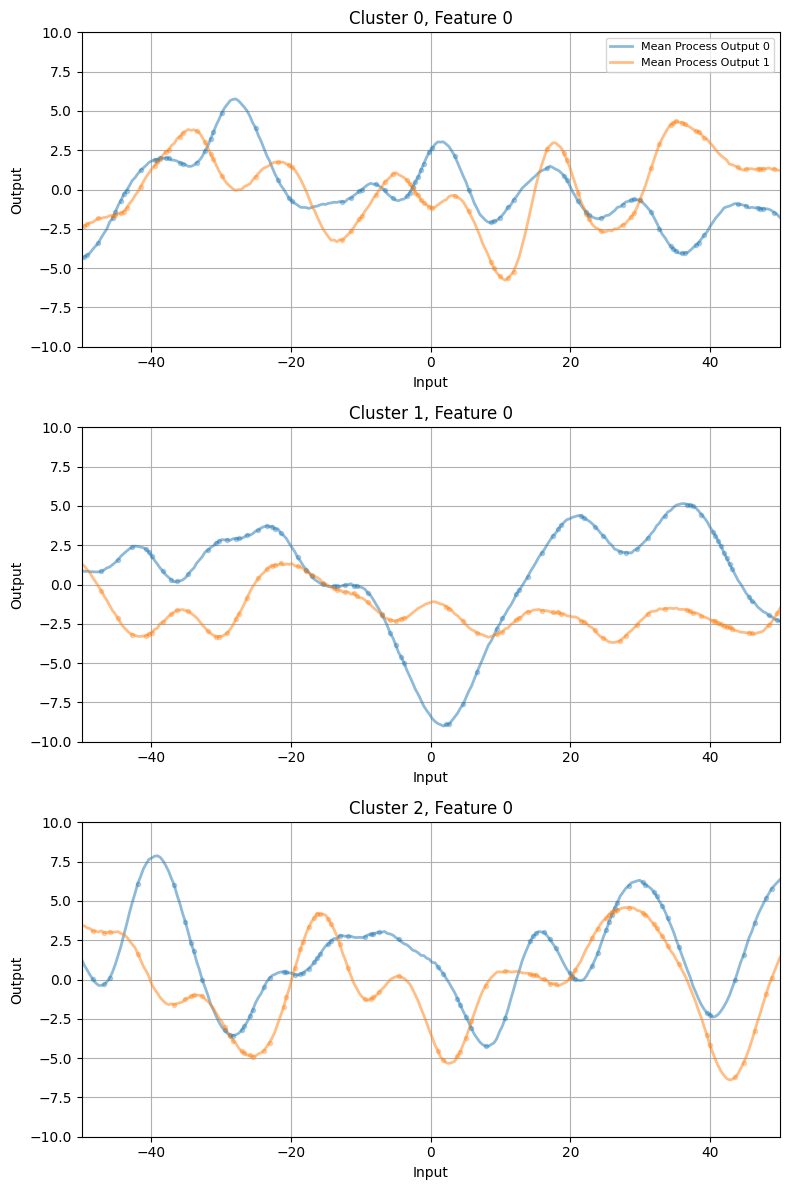

In [46]:
plot_task_means_1D(g, m_p, f_i, t_m, mix)

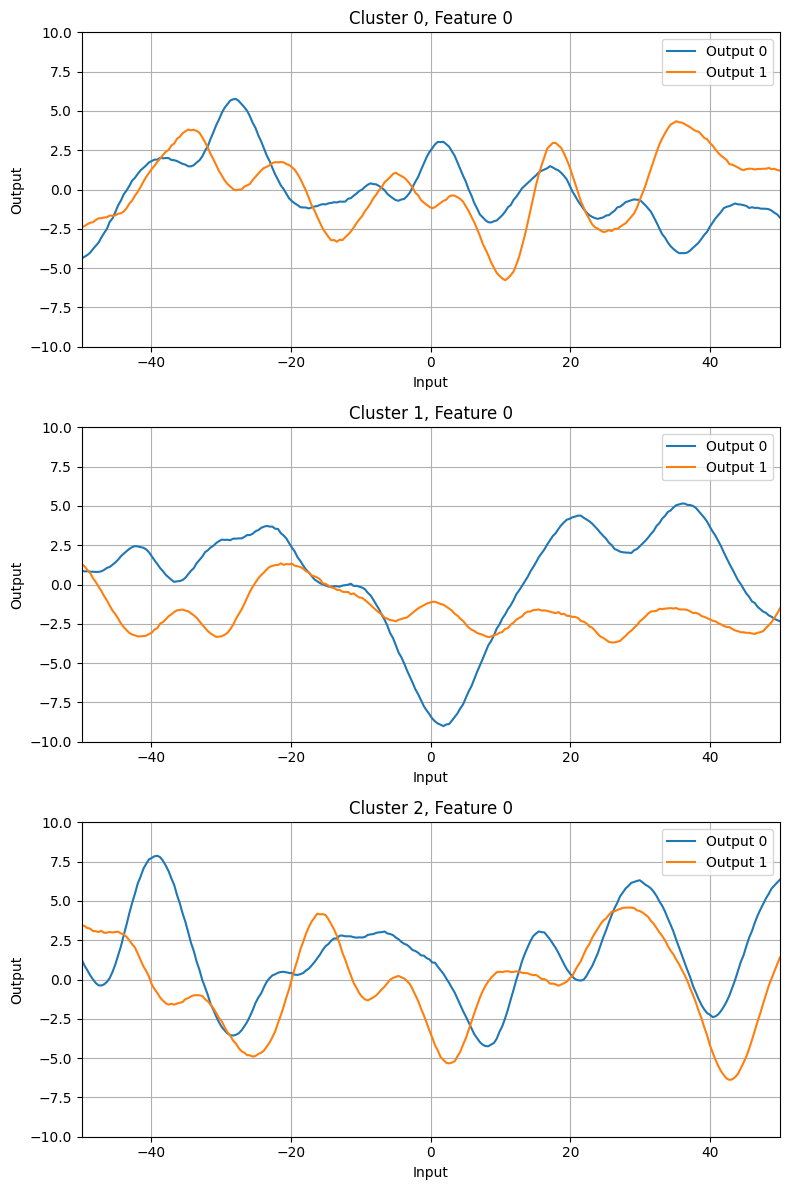

In [24]:
if I == 1:
	plot_processes_1D(g, m_p)
elif I == 2:
	plot_processes_2D(g, m_p)

In [25]:
0/0

ZeroDivisionError: division by zero

In [ ]:
# Check for errors
for sth in (True, False):
	for ch in (True, False):
		for fh in (True, False):
			for I in (1, 2):
				for soh in (True, False):
					for siit in (True, False):
						for siif in (True, False):
							try:
								k = jr.PRNGKey(42)
								generate_data(k, 4, 2, 3, 7, I, 2, 100 if I == 1 else 40, sth, ch, fh, False, soh, siit, siif)
								print(f"OK - {sth}, {ch}, {fh}, {I}, {soh}, {siit}, {siif}")
							except Exception as e:
								print(f"KO - {sth}, {ch}, {fh}, {I}, {soh}, {siit}, {siif} - {e}")

OK - True, True, True, 1, True, True, True
OK - True, True, True, 1, True, True, False
OK - True, True, True, 1, True, False, True
OK - True, True, True, 1, True, False, False
OK - True, True, True, 1, False, True, True
OK - True, True, True, 1, False, True, False


In [ ]:
# Perform 1000 générations, collect hyper-parameters and whether the generation produced NaNs
# Save HPs and NaN status in a csv file for analysis
with open("hp_nan_analysis.csv", "a") as f:
	# Write header
	f.write("ls_1,ls_2,ls_u,var_1,var_2,has_nans\n")

	for i in range(1000):
		key, k = jr.split(key)
		T=10 ; K=3 ; F=2 ; N=10 ; I=2 ; O=1 ; G=50
		#                     generate_data(k, T, K, F, N,  I, O, G,  sth,   ch,    fh,   ai,   soh,   siit,  siif)
		i, g, m_k, t_k, m_p = generate_data(k, T, K, F, N,  I, O, G, True, False, True, False, True, True, True)

		# Extract HPs
		ls_1, ls_2 = m_k.inner_kernel.inner_kernel.inner_kernel.length_scale
		ls_u = m_k.inner_kernel.inner_kernel.inner_kernel.length_scale_u
		var_1, var_2 = m_k.inner_kernel.inner_kernel.inner_kernel.variance

		# Check for NaNs in mean processes
		has_nans = jnp.any(jnp.isnan(m_p))

		# Save to csv
		f.write(f"{ls_1.item()},{ls_2.item()},{ls_u.item()},{var_1.item()},{var_2.item()},{has_nans}\n")

NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00% of values are NaN)
NaNs in mean processes (100.00%

---